# Landsat Multi-Temporal Composites

In remote sensing, we usually work on single images ("scenes") acquired on a given date over a given area. While this sufficient or even necessary for many applications such as the studying of vegetation dynamics, some applications actually require information combined from many scenes, i.e., multiple "snapshots" of an area over time.

Single scenes tend to be noisy mostly because of atmospheric disturbances and instrumentation errors. Thus single scenes might contain significant parts of no-data or poor-quality pixels due to instrument failures, clouds (in the case of optical imagery) or shadows. Taking multiple scenes acquired at different points in time and aggregating them over time by a statistical measure such as the mean or median is therefore in some cases the preferred choice.

Multi-temporal composites are used for many different applications, including

* inputs for classification tasks such as land-use/ land-cover mapping
* generation of equidistant time series
* generation of basemaps

to name a few.

In this notebook, you will learn how to generate a multi-temporal mosaic of Landsat8-9 scenes acquired in Spring 2022. Our example covers a full month (May 2022). The steps are:

1. We fetch the Landsat scenes overlapping our study region
2. We aggregate the Landsat scenes into a single multi-temporal composite using the median, i.e., our composite will contain the median reflectance obtained from all Landsat scenes fetched in May 2022


In [53]:
# we have to install the development version for the time being
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal@landsat-dev

## Setting up the EOdal Mapper

In [54]:
year = 2021

In [55]:
from datetime import datetime
from pathlib import Path
from shapely.geometry import box
from matplotlib import pyplot as plt

from eodal.config import get_settings
from eodal.core.sensors import Landsat
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs


Settings = get_settings()
# we use STAC, i.e., Microsoft Planetary Computer
Settings.USE_STAC = True

# user-inputs
# -------------------------- Collection -------------------------------
collection = 'landsat-c2-l2'

# ---------------------- Spatial Feature  ------------------------------
bbox = box(*[30.2825, 0.4019, 30.3714, 0.4643])  # can be also shp, gpkg, etc.
feature = Feature(
    name='landsat-composite',
    geometry=bbox,
    epsg=4326,
    attributes={})

# ------------------------- Time Range ---------------------------------
time_start = datetime(year, 1, 1)
time_end = datetime(year, 12, 31)

# ------------------------- Metadata Filters ---------------------------
metadata_filters = [
    Filter('eo:cloud_cover', '<', 30),
    Filter('landsat:wrs_path', '==', '173'),
    Filter('landsat:wrs_row', '==', '060'),
    Filter('instruments', '==', 'oli')
]

# set up the Mapper configuration
mapper_configs = MapperConfigs(
    metadata_filters=metadata_filters,
    collection=collection,
    feature=feature,
    time_start=time_start,
    time_end=time_end)

# get a new mapper instance
mapper = Mapper(mapper_configs)
mapper

EOdal Mapper
EOdal MapperConfig
------------------
Collection: landsat-c2-l2
Time Range: 2021-01-01 00:00:00 - 2021-12-31 00:00:00
Feature:
Name		landsat-composite
Geometry	POLYGON ((30.3714 0.4019, 30.3714 0.4643, 30.2825 0.4643, 30.2825 0.4019, 30.3714 0.4019))
EPSG Code	4326
Attributes	{}
Metadata Filters: [eo:cloud_cover < 30, landsat:wrs_path == 173, landsat:wrs_row == 060, instruments == oli]
Data Source: STAC (https://planetarycomputer.microsoft.com/api/stac/v1)

In [56]:
# define a function to mask clouds and shadows
def prepocess_landsat_scene(
        ds: Landsat
) -> Landsat:
    """
    Mask clouds and cloud shadows in a Landsat scene based
    on the 'qa_pixel' band.

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
        interfacing libraries!

    :param ds:
        Landsat scene before cloud mask applied.
    :return:
        Landsat scene with clouds and cloud shadows masked.
    """
    ds.mask_clouds_and_shadows(inplace=True)
    return ds

## Query the data


In [57]:

# fetch the metadata
# query the scenes available (no I/O of scenes, this only fetches metadata)
mapper.query_scenes()


In [58]:

# the metadata is stored as a GeoDataFrame
mapper.metadata.head()

print(f'Number of Landsat scenes found: {mapper.metadata.shape[0]}')


Number of Landsat scenes found: 7


In [59]:
# we tell EOdal how to load the Landsat scenes using `Landsat.from_usgs`
# and pass on some kwargs, e.g., the selection of bands we want to read.
# in addition, we tell EOdal to mask out clouds and shadows and the fly
# while reading the data using the qa_pixel band (therefore, we set the
# `read_qa` flag to True.

scene_kwargs = {
    'scene_constructor': Landsat.from_usgs,
    'scene_constructor_kwargs': {
        'band_selection': ['blue', 'green', 'red', 'nir08', 'swir16', 'qa_pixel'], 
        'read_qa': False},
    'scene_modifier': prepocess_landsat_scene,
    'scene_modifier_kwargs': {}}

# now we load the scenes
mapper.load_scenes(scene_kwargs=scene_kwargs)

# the scenes are loaded into a EOdal SceneCollection object
mapper.data

2023-06-21 11:32:44,319 eodal        INFO     Starting extraction of landsat scenes


2023-06-21 11:33:01,886 eodal        INFO     Finished extraction of landsat scenes


EOdal SceneCollection
----------------------
# Scenes:    7
Timestamps:    2021-02-09 00:00:00, 2021-03-29 00:00:00, 2021-04-14 00:00:00, 2021-05-16 00:00:00, 2021-07-03 00:00:00, 2021-07-19 00:00:00, 2021-10-23 00:00:00
Scene Identifiers:    LC08_L2SP_173060_20210209_20210302_02_T1, LC08_L2SP_173060_20210329_20210408_02_T2, LC08_L2SP_173060_20210414_20210423_02_T1, LC08_L2SP_173060_20210516_20210525_02_T1, LC08_L2SP_173060_20210703_20210712_02_T1, LC08_L2SP_173060_20210719_20210729_02_T1, LC08_L2SP_173060_20211023_20211103_02_T1

In [60]:
# all scenes have the same shape, i.e., the same number of bands, rows and columns
shapes = [{timestamp: scene.get_values().shape} for timestamp, scene in mapper.data]
shapes

[{datetime.datetime(2021, 2, 9, 0, 0): (6, 232, 332)},
 {datetime.datetime(2021, 3, 29, 0, 0): (6, 232, 332)},
 {datetime.datetime(2021, 4, 14, 0, 0): (6, 232, 332)},
 {datetime.datetime(2021, 5, 16, 0, 0): (6, 232, 332)},
 {datetime.datetime(2021, 7, 3, 0, 0): (6, 232, 332)},
 {datetime.datetime(2021, 7, 19, 0, 0): (6, 232, 332)},
 {datetime.datetime(2021, 10, 23, 0, 0): (6, 232, 332)}]

## Display the single scenes

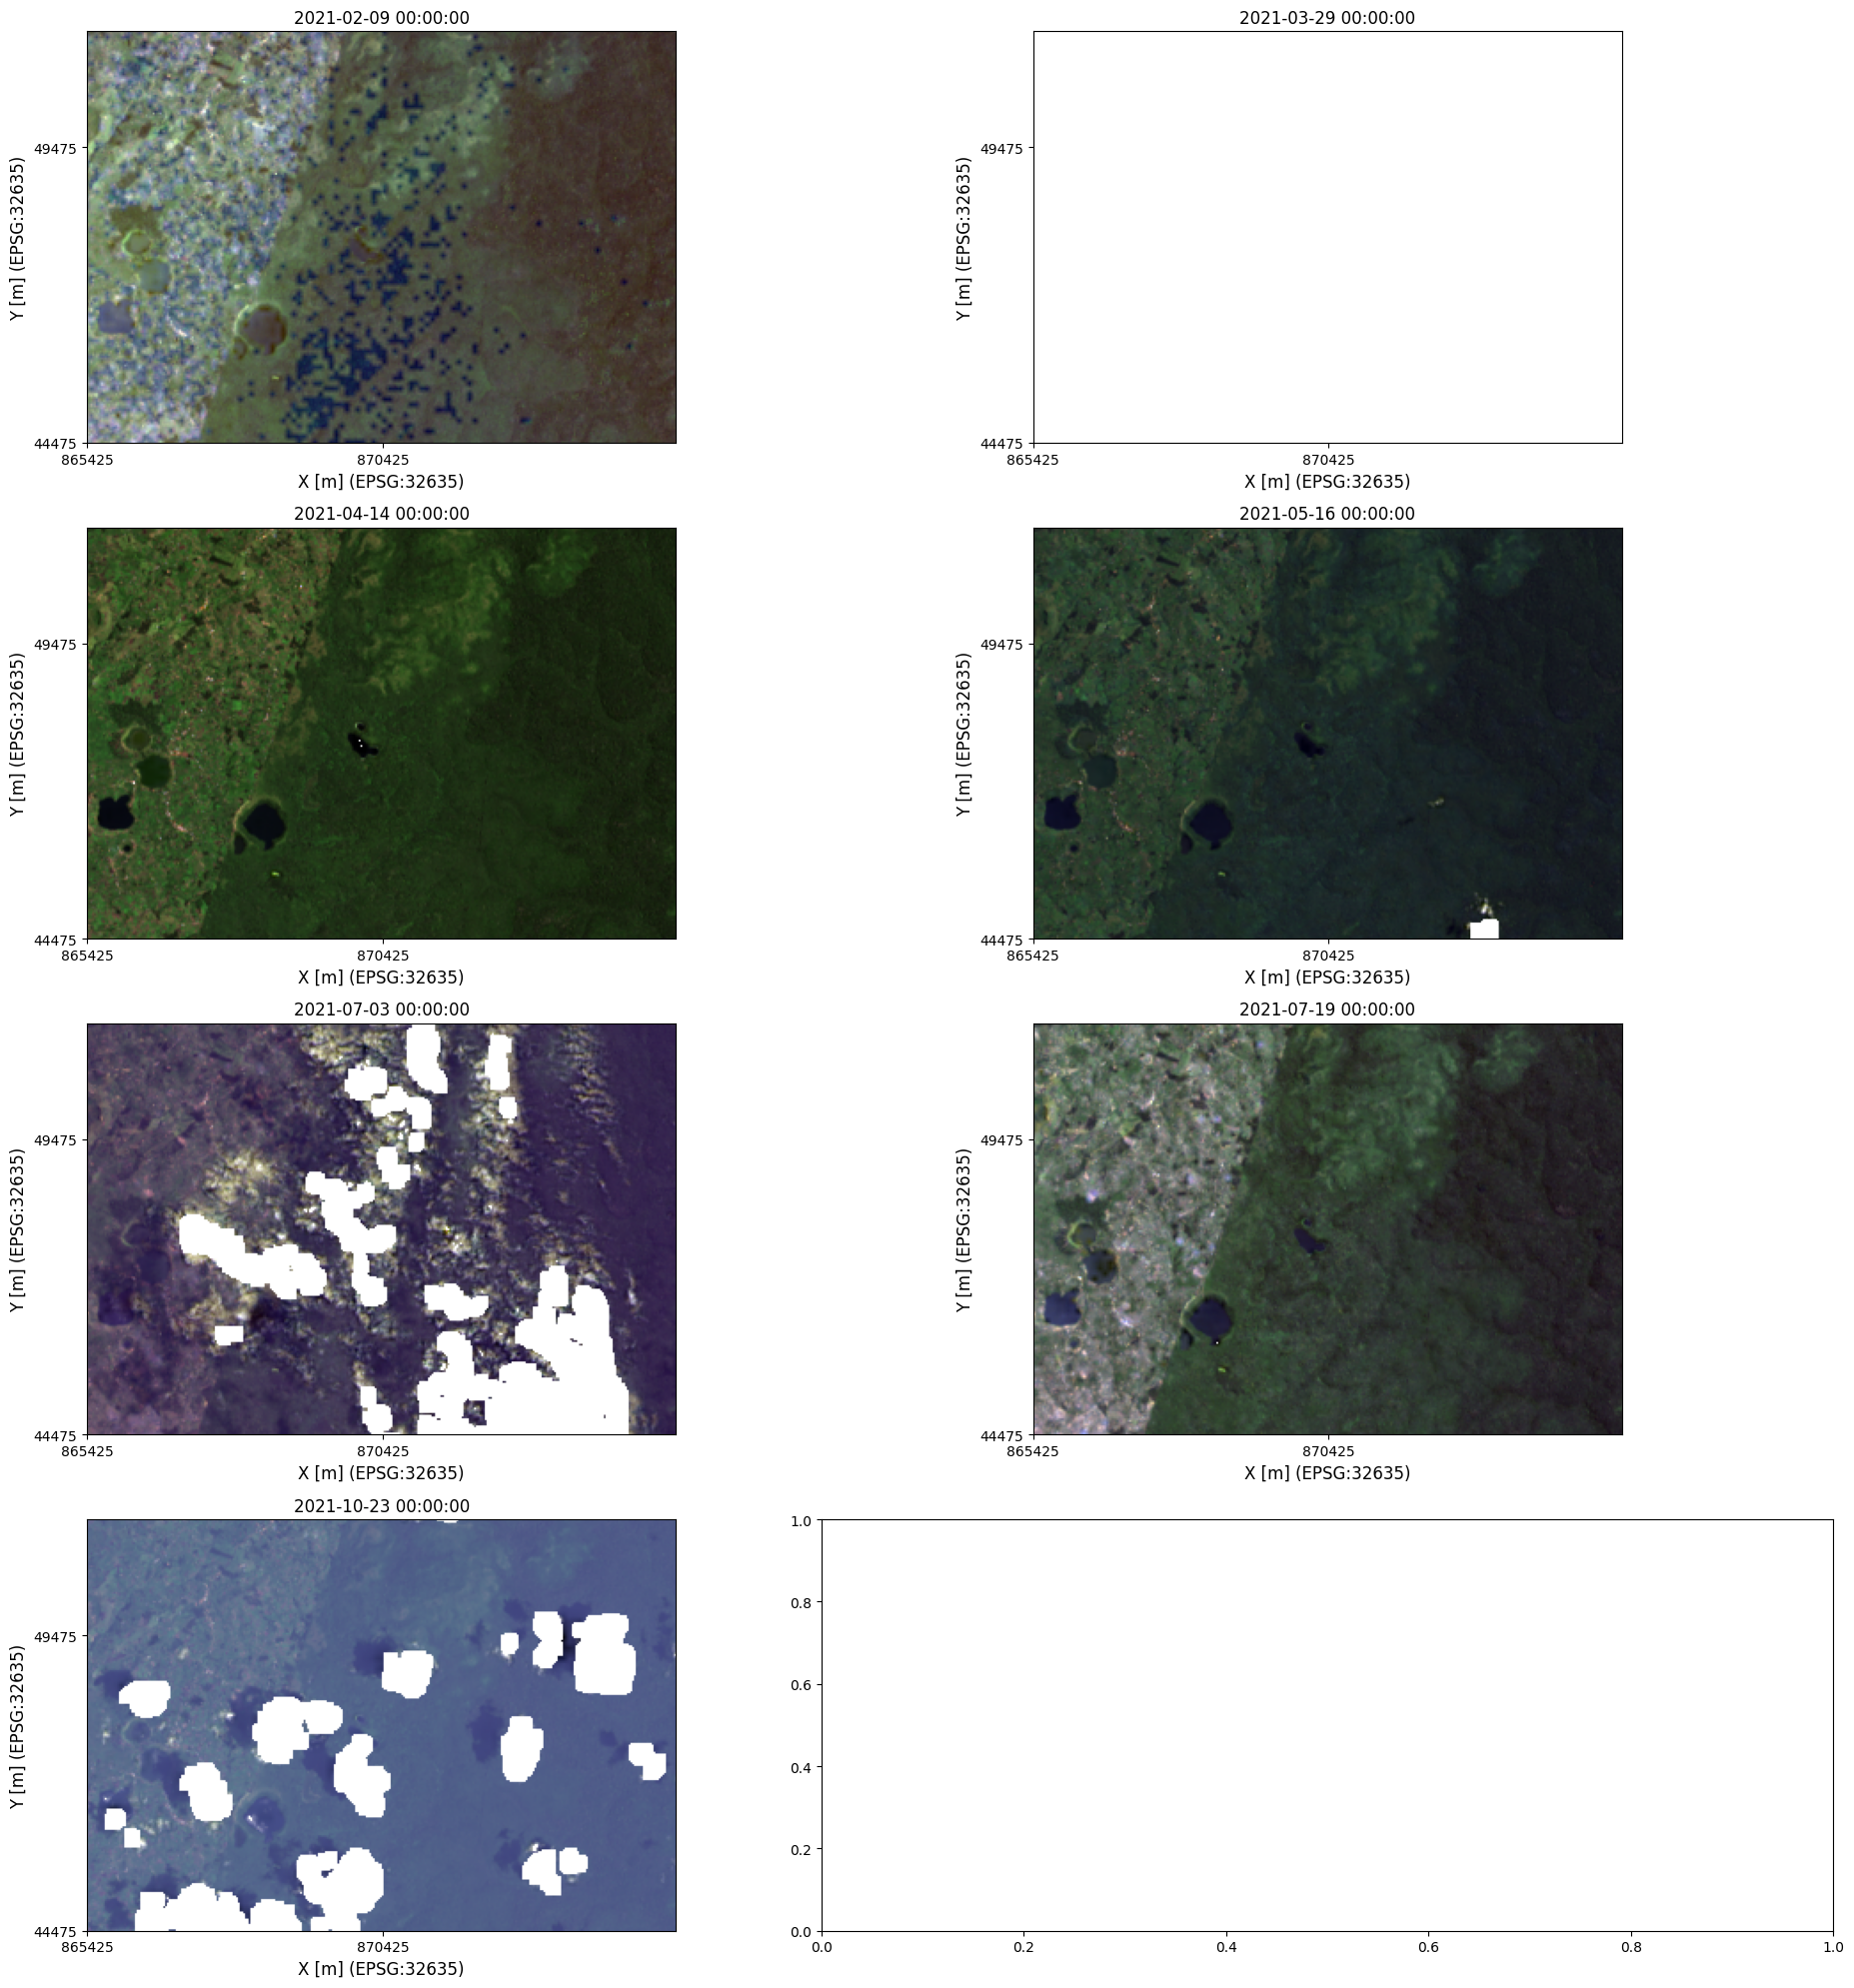

In [61]:

# The mapper returns the single scenes. As we told the EOdal to mask out clouds, a significant share if the pixels is masked out. We will aggregate them in the next step.
f = mapper.data.plot(band_selection=['red', 'green', 'blue'], figsize = (20, 20), max_scenes_in_row = 2)

## Generating the composite

We will now generate the composite. Here, we have to consider two things:

1. The data is stored as [numpy masked arrays](https://numpy.org/doc/stable/reference/maskedarray.generic.html) as we masked out clouds.
2. We therefore have to use masked arrays and the numpy ma functions that work on numpy masked arrays (i.e., the ignore masked values).

First, we open masked arrays for storing the data:


In [62]:

import numpy as np

# open arrays for storing the data per band
shape = (len(mapper.data), list(shapes[0].values())[0][1], list(shapes[0].values())[0][2])
blue = np.ma.masked_array(data=np.ndarray(shape, dtype=float), mask=False)
red = np.zeros_like(blue)
green = np.zeros_like(blue)
nir08 = np.zeros_like(blue)
swir16 = np.zeros_like(blue)


In [63]:

# Next, we loop over the scenes.
idx = 0
for _, scene in mapper.data:
    blue[idx, :, :] = scene['blue'].values
    red[idx, :, :] = scene['red'].values
    green[idx, :, :] = scene['green'].values
    nir08[idx, :, :] = scene['nir08'].values
    swir16[idx, :, :] = scene['swir16'].values
    idx += 1


In [64]:
# Finally, we aggregate the data using the median reflectance. Since we deal with masked arrays, we have to call [numpy.ma.median](https://numpy.org/doc/stable/reference/generated/numpy.ma.median.html) instead of the "normal" numpy.median function.
# calculate the median reflectance per spectral band
blue_median = np.ma.median(blue, axis=0)
green_median = np.ma.median(green, axis=0)
red_median = np.ma.median(red, axis=0)
nir08_median = np.ma.median(nir08, axis=0)
swir16_median = np.ma.median(swir16, axis=0)

We store the results in a new RasterCollection
save the median reflectance to a new RasterCollection


In [65]:

from eodal.core.band import GeoInfo, Band
from eodal.core.raster import RasterCollection

rc = RasterCollection()

bands = {'blue': blue_median, 
        'green': green_median, 
        'red': red_median, 
        'nir08' : nir08_median, 
        'swir16' : swir16_median}

for band_name, band_value in bands.items():
    rc.add_band(
        band_constructor=Band,
        values=band_value,
        band_name=f'{band_name}_median',
        geo_info=scene[band_name].geo_info)

rc


EOdal RasterCollection
----------------------
# Bands:    5
Band names:    blue_median, green_median, red_median, nir08_median, swir16_median
Band aliases:    

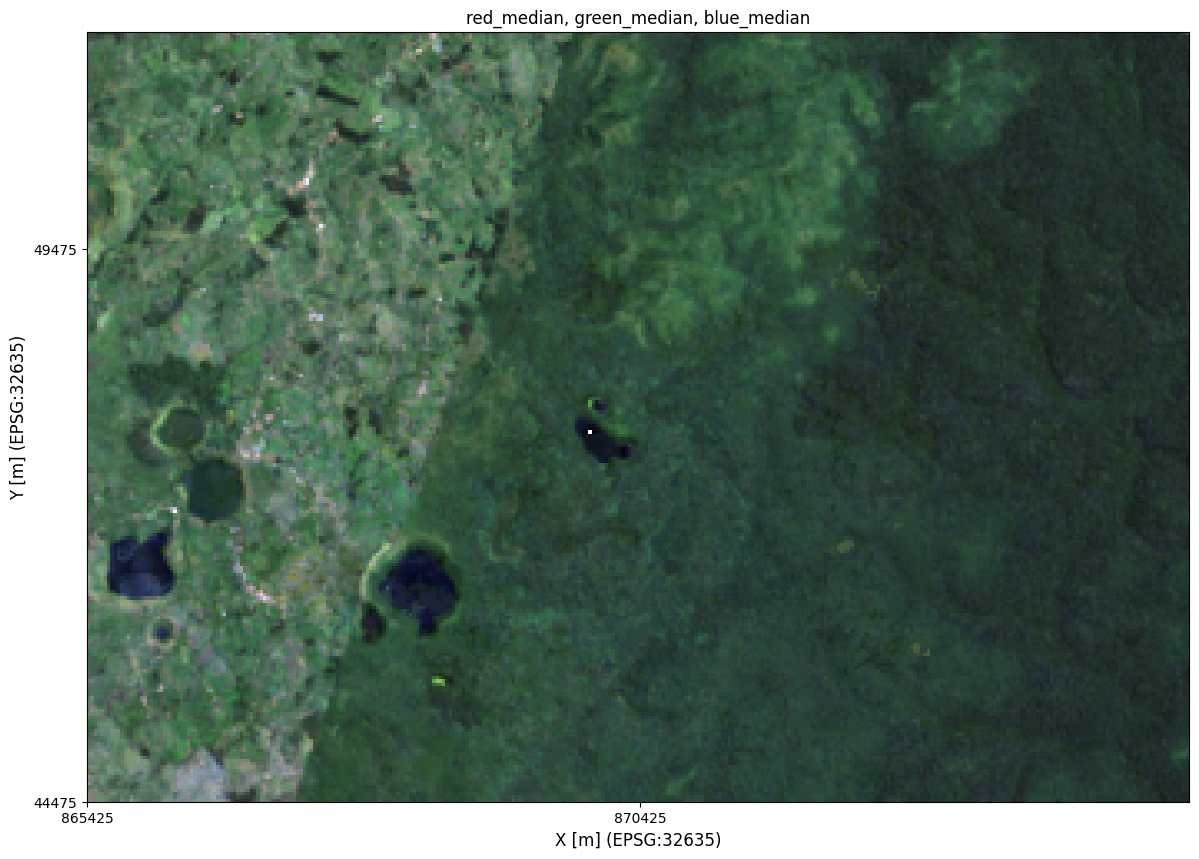

In [66]:
# We plot the result and save it as GeoTiff (optional). As you can see, after the compositing there are still some no-data pixels left (white areas). This is because for some locations there were not enough cloud-free observations to compute the median - especially in the eastern part of the study area. This is most likely due to [Landsat orbit design and overpass frequency]().
f, ax = plt.subplots(figsize = (20, 10))

f = rc.plot_multiple_bands(['red_median', 'green_median', 'blue_median'], ax=ax)

# save as GeoTiff
rc.to_rasterio('S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_' + str(year) + '.tif')